# COMUNET analysis

## Functions

In [1]:
options(stringsAsFactors = FALSE)

# Functions ####

# make a function to check NAs
# INPUT: 
#       objectToCheck: a vector or matrix containing any values
# OUPUT:
#       a warning message is case the object contains NAs
checkNAs <- function(objectToCheck){
        if(!all(!is.na(objectToCheck))) stop("WARNING: the object contains NAs.")
}

stepFunc <- function(x) {as.integer(x != 0)}

# prevent dropping dimensions
`[` <- function(...) base::`[`(...,drop=FALSE)

# filter out layers with no edges
filterEmptyLayers <- function(weight_array
                              ,ligandReceptorPairList
){
        # check which layers have no edges
        noEdgeLayers <- sapply(1:nrow(ligandReceptorPairList)
                               ,function(layer){
                                       sum(weight_array[,,layer]) == 0
                               })
        names(noEdgeLayers) <- dimnames(weight_array)[3]
        # delete these layers form ligandReceptorPairList
        ligandReceptorPairList <- ligandReceptorPairList[!noEdgeLayers,]
        # delete these layers from the array of the adjacency matrices
        weight_array <- weight_array[,,!noEdgeLayers]
        # return
        return(list(ligandReceptorPairList = ligandReceptorPairList
                    ,weight_array = weight_array
        )
        )
}


# calculate an array of three dimentions: (nr of nodes) x (nr of degrees) x (nr of layerse).
# nr of nodes is N
# nr of degrees in 3: in- out- and (out-in)-
# nr of layers is M
#function to calculate degree
calcDegrees <- function(weight_array
){
        N <- dim(weight_array)[1]
        M <- dim(weight_array)[3]
        # make a dummy array
        myDegreeArray <- array(NA
                               ,dim = c(N,3,M)
        )
        
        # add dimention names
        dimnames(myDegreeArray) <- list(dimnames(weight_array)[[1]]
                                        ,c("in", "out", "delta")
                                        ,dimnames(weight_array)[[3]]
        )
        myDegreeArray[,"in",] <- colSums(weight_array)
        myDegreeArray[,"out",] <- colSums(aperm(weight_array
                                                ,c(2,1,3)))
        myDegreeArray[,"delta",] <- myDegreeArray[,"out",] - myDegreeArray[,"in",]
        # check NAs
        checkNAs(myDegreeArray)
        # return myDegreeArray
        myDegreeArray
}

# dissimilarity function
# IN
#       adj1: numeric matrix [0,1], adjacency matrix for the layer 1
#       adj2: numeric matrix [0,1], adjacency matrix for the layer 2
# OUT
#       dissimCoefficient: numeric [0,1], the dissimilarity coefficient for the two layers. The identical matrices will have a coefficient of 0 and completely different matrices will have a coefficient of 1
d <- function(adj1, adj2){
        # make a union adjacenc matrix: 
        # 1. allpy theta funciton on each of the two matrices to convert weights into zeros and ones
        # 2. then perform bitwise or operation to get the union matrix
        unionOfEdges <- apply(adj1, 1:2, stepFunc) | apply(adj2, 1:2, stepFunc)
        # calculate the number of egdes in the union
        n_unionOfEdges <- sum(unionOfEdges)
        
        if(n_unionOfEdges == 0) myDissim <- 1 else {
                # calculate the sum of normalized weight differences
                # matrix of absolute differences of weights for each edge
                absWeightDifference <- abs(adj1 - adj2)
                # matrix of sum of weights for each edge
                wightSum <- adj1 + adj2
                # Convert zeros to -1 to avoid division by zero in the next step
                wightSum[wightSum == 0] <- -1
                # matrix of normalized differences 
                normWeightDifference <- absWeightDifference / wightSum
                # 
                normWeightDifferenceSum <- sum(normWeightDifference)
                myDissim <- normWeightDifferenceSum / n_unionOfEdges
        }
        myDissim
}

# calcualte dissimilatriy
calc_dissimMatrix <- function(weight_array1
                              ,weight_array2
){
        N <- dim(weight_array1)[[3]]
        M <- dim(weight_array2)[[3]]
        # make a dummy matrix
        dissimMatrix <- matrix(NA
                               ,nrow = N
                               ,ncol = M
        )
        # calculate an N x M dissimillarity matrix for all layers
        if(identical(weight_array1,weight_array2)) { # if it is the same weight matrix, calculate only the upper triangular matrix
                # populaate diagolan with 0
                diag(dissimMatrix) <- 0
                
                for (i in 1:(N-1)){
                        for(j in (i+1):M){
                                dissimValue <- d(weight_array1[,,i]
                                                 ,weight_array2[,,j]
                                )
                                dissimMatrix[i,j] <- dissimValue
                                dissimMatrix[j,i] <- dissimValue
                        }
                }
        } else {
                for (i in 1:N){
                        for(j in 1:M){
                                dissimValue <- d(weight_array1[,,i]
                                                 ,weight_array2[,,j]
                                )
                                dissimMatrix[i,j] <- dissimValue
                        }
                }
        }
        
        checkNAs(dissimMatrix)
        dimnames(dissimMatrix) <- list(dimnames(weight_array1)[[3]]
                                       ,dimnames(weight_array2)[[3]]
        )
        dissimMatrix
}

# assings color to each node according to its delta degree
deltaDegreeToColor <- function(deltaDegreeVector
                               ,nodes
){
        fine <- round(max(abs(deltaDegreeVector)) 
                      ,2) * 100 * 2 + 2
        if(fine == 2) {
                colors <- rep("gray40"#FFFFFF"
                              ,length(deltaDegreeVector))
                names(colors) <- nodes
                colors
        } else {
                palette <- colorRampPalette(c("blue"
                                              , "gray40"
                                              , "red"
                )
                )
                sapply(deltaDegreeVector
                       ,function(i){
                               palette(fine)[ceiling(round(i,2)*100 
                                                     + ((fine - 1)/2)
                               )
                               ]
                       })       
        }
}


# define a function to plot a community
plotCommunicationGraph <- function(adjacencyMatrix
                          ,degreeMatrix
                          ,nodes
                          ,title
                          ,subtitle = ""
){
        # create a directed weighted graph object
        layer_graph <- igraph::graph.adjacency(adjacencyMatrix
                                               ,mode = "directed"
                                               ,weighted = T
        )
        
        # add color scheme to the graph object
        colors <- deltaDegreeToColor(degreeMatrix[,3,1]
                                     ,nodes)
        V(layer_graph)$color <- colors
        edge.arrow.size <- 0.5
        colormap <- colorRampPalette(c(min(colors)
                                       ,"gray40"
                                       ,max(colors)
        ))(20)
        leg.labels <- c(round(min(degreeMatrix[,3,1]),2)
                                      ,round(max(degreeMatrix[,3,1]),1)
        )
        leg.title <- expression(Delta)#"delta\ndegree"
        
        # add label size to the graph object
        V(layer_graph)$label.cex = 1#1.75
        
        V(layer_graph)$size = 20
        
        # set seed
        set.seed(1123)
        
        # create a plot
        plot.igraph(layer_graph
                    ,edge.width=(E(layer_graph)$weight/max(E(layer_graph)$weight))*2.5
                    ,edge.arrow.size = edge.arrow.size
                    ,layout = layout.circle(layer_graph)
                    ,edge.curved=TRUE
                    ,vertex.label.color=V(layer_graph)$color
                    ,vertex.shape="none"
                    ,main = title
                    ,sub = subtitle
        )
        #points for the gradient legend
        pnts = cbind(x =c(1.15
                          ,1.25
                          ,1.25
                          ,1.15)
                     , y =c(-0.5,-0.5,-1,-1)
        )
        #create the gradient legend
        legend.gradient(pnts
                        ,colormap
                        ,leg.labels
                        ,title = leg.title
                        ,cex = 0.75
        )
        
        
}

# function to plot a graph with ligands (red) and receptors (blue) in a particular cluster
plotLigRec <- function(clusterOfInterest
                       ,lrp.clusters
                       ,ligandReceptorPairList
){
        # make adjacency matrix: 
        # rows contain ligands
        # colomns contain receptors
        # 1 if ligand and receptor is a pair, 0 if ligand and receptor is no pair
        lrp <- ligandReceptorPairList[lrp.clusters == clusterOfInterest,]
        ligands <- unique(lrp$ligand)
        receptors <- unique(lrp$receptor)
        adjMat <- matrix(0
                         ,nrow = length(ligands) + length(receptors)
                         ,ncol = length(ligands) + length(receptors)
        )
        dimnames(adjMat) <- list(c(ligands,receptors)
                                 ,c(ligands,receptors)
        )
        for(idx in 1:nrow(lrp)){
                idxRow <- which(lrp$ligand[idx] == rownames(adjMat))
                idxCol <- which(lrp$receptor[idx] == colnames(adjMat))
                adjMat[idxRow, idxCol] <- 1
        }
        
        # create a directed weighted graph object
        lrp_graph <- igraph::graph.adjacency(adjMat
                                             ,mode = "directed"
                                             # ,weighted = F
        )
        # add color
        V(lrp_graph)$color <- {
                color <- c(rep("red"
                               ,length(ligands))
                           ,rep("blue"
                                ,length(receptors)))
                names(color) <- c(ligands
                                  ,receptors)
                color <- color[colnames(adjMat)]
                color
        }
        legend.lab <- c("ligand"
                        ,"receptor")
        legend.col <- c("red"
                        ,"blue")
        title <- paste("cluster"
                       ,clusterOfInterest)
        
        edge.arrow.size <-  0.25
        
        # set seed
        set.seed(1123)
        
        # create a plot
        plot.igraph(lrp_graph
                    ,edge.arrow.size = 0.25
                    ,vertex.label.color=V(lrp_graph)$color
                    #,vertex.label.cex = 0.5
                    ,vertex.shape="none"
                    ,edge.curved=F
                    ,main = title
                    ,layout=layout_with_kk
        )
        legend(x=-1
               ,y=-1.1
               ,legend = legend.lab
               ,pch=21
               #,col=legend.col
               ,pt.bg=legend.col
               ,pt.cex=2
               ,cex=.8
               ,bty="n"
               ,ncol=1
               )
}

# plot log10 expression for ligand(s) and receptor(s) in a pair
plotExprs <- function(exprsMatrix
                      ,annotation
                      ,gene
                      ,title
){
        df <- data.frame(log10_expression = as.vector(log10(exprsMatrix[as.character(gene),] +1))
                         ,nodes = annotation$cell_type
        )
        xlabs <- levels(as.factor(annotation$cell_type))
        pirateplot(log10_expression ~ nodes
                   ,data = df
                   ,pal =  "southpark"#"info"
                   ,theme = 3
                   ,main = title
                   ,cex.axis = 0.5
                   ,cex.names = 0.5
                   ,gl.lty = 0 # remove horizontal grid lines
                   ,xaxt = "n"
                   ,xlab = ""
        )
        text(1:length(xlabs)+0.55
             ,par("usr")[3]-0.05
             ,cex = 0.5
             , labels = xlabs
             , srt = 45
             , pos = 2
             , xpd = TRUE)
}

# layout plot for communication graph of a ligand-receptor pair and log10 expression for the ligand(s) and receptor(s) in this pair
combinedPlot <- function(idx
                         ,adjacencyMatrix
                         ,degreeMatrix
                         ,nodes
                         ,ligandReceptorPairList
                         ,layout_title = ""
                         ,subtitle = ""
                         ,complex_input
                         ,gene_input
                         ,exprsMatrix
                         ,annotation
                         ){
        #####
        title <- ligandReceptorPairList$pair[idx]
        title <- gsub("_"
                      ,":"
                      ,title)
        title <- gsub(" "
                      ,"_"
                      ,title)
        ligand <- ligandReceptorPairList$ligand[idx]
        # in case of ligand being a complex, what are the genes in the comples
        ligand_genes <- complex2genes(complex = ligand
                                      ,complex_input = complex_input
                                      ,gene_input = gene_input
                                      )
        # if redundant ensembl IDs, remove all that are not in the expression matirx
        ligand_genes <- ligand_genes[ligand_genes %in% rownames(exprsMatrix)]
        receptor <- ligandReceptorPairList$receptor[idx]
        receptor_genes <- complex2genes(complex = receptor
                                        ,complex_input = complex_input
                                        ,gene_input = gene_input
                                        )
        # if reundant ensembl IDs, remove all that are not in the expression matirx
        receptor_genes <- receptor_genes[receptor_genes %in% rownames(exprsMatrix)]
        nrow_layout <- max(length(ligand_genes)
                           ,length(receptor_genes)
        )
        # indices of individual expression plots in the layout
        plotIDs <- rep(0
                       ,nrow_layout * 3)
        # ID for communication plot
        plotIDs[1] <- 1
        # IDs for ligand expression
        plotIDs[(nrow_layout +1)
                :(nrow_layout + length(ligand_genes))] <- 1+c(1:length(ligand_genes))
        # IDs for receptor expression
        plotIDs[(nrow_layout*2 +1)
                :(nrow_layout*2 + length(receptor_genes))] <- 1+length(ligand_genes)+c(1:length(receptor_genes))
        # make layout
        layout.mat <- matrix(plotIDs
                             ,nrow = nrow_layout
                             ,ncol = 3
                             ,byrow = F
        )
        if(nrow_layout <= 2) heights <- 7 else heights <- 15/ nrow_layout
        layout(layout.mat
               ,widths = lcm(5)
               ,heights = lcm(heights)
        )
        par(oma = c(0, 0, 4, 0))
        #####
        plotCommunicationGraph(adjacencyMatrix = adjacencyMatrix
                               ,degreeMatrix = degreeMatrix
                               ,nodes = nodes
                               ,title = title
                               ,subtitle = subtitle
        )
        for(partner in c(ligand
                         ,receptor)
        ){
                title <-  partner
                if(partner == ligand) genes <- ligand_genes else genes <- receptor_genes
                # plot stuff
                for(gene in genes){
                        title <- genes[as.logical(genes == gene)]
                        plotExprs(exprsMatrix = exprsMatrix
                                  ,annotation = annotation
                                  ,gene = gene
                                  ,title = title
                        )
                }
        }
        title(layout_title
              ,outer = TRUE
              ,line = 0)
}

# in case of a complex ligand / receptor, converts the complex name into a vector of individual ligands / receptors that comprize the complex
complex2genes <- function(complex
                          ,complex_input
                          ,gene_input
){
        if(complex %in% complex_input$complex_name){
                uniprots <- complex_input[complex_input$complex_name == complex
                                          ,2:5]
                # remove NA and ""
                uniprots <- uniprots[(!is.na(uniprots)) & (!(uniprots == "")) ]
                # translate uniprots to given gene names
                genes <- sapply(uniprots
                                ,function(uniprot) {
                                        unlist(gene_input[gene_input$uniprot == uniprot
                                                   ,"gene_name"])
                                }
                )
                genes
        } else {
                gene <- unique(unlist(gene_input[gene_input$gene_name == complex
                                          ,"gene_name"]))
                gene
        }
}

# converts CellPhoneDB output matrix (significant_means.txt) into an array of weighted adjacency matrices
# IN:
#       CellPhoneDB_output      significant_means.txt file in the output of CellPhoneDB
#       complex_input           complex_input.csv file. Donwload from CellPhoneDB
#       gene_input              gene_input.csv file. Donwload from CellPhoneDB
# OUT:
#       list of:
#               w_array: numeric array                   array of weighted adjacency matrices
#               ligandReceptorPairList: dataframe        data frame with columns "pair", "ligand", "ligand_complex_composition", "receptor", "receptor_complex_composition"
convert_CellPhoneDB_output <- function(CellPhoneDB_output
                        ,complex_input # donwload from CellPhoneDB
                        ,gene_input # donwload from CellPhoneDB
){
        # make ligand-receptor pair list
        # ligandReceptorPairList is data frame with columns "pair", "ligand", "ligand_complex_composition", "receptor", "receptor_complex_composition"
        # "pair" contains values in a form "ligand:receptor", i.e. ligand being at the first place, receptor being at the second place, e.g. "TNFSF13:TNFRSF17"
        # "ligand" contains ligand names, e.g. "TNFSF13"
        # "ligand_complex_composition" if ligand is a complex (e.g. "aXb2_complex"), contains genes in the ligand complex separated with a comma, e.g. "ITGAX,ITGB2", else contains ""
        # "receptor" contains receptor names, e.g. "TNFRSF17"
        # "receptor_complex_composition" if receptor is a complex (e.g. "NKG2D_II_receptor"), contains genes in the receptor complex separated with a comma, e.g. "KLRK1,HCST", else contains ""
        
        # sort out ligands and receptors: each pair will have a form "ligand:receptor"
        
        # indices of receptors
        idxReceptor <- as.matrix(data.frame(a = CellPhoneDB_output$receptor_a
                                            ,b = CellPhoneDB_output$receptor_b))
        rownames(idxReceptor) <- CellPhoneDB_output$interacting_pair
        
        # which pairs are directed
        idxDirected <- rowSums(idxReceptor) == 1
        
        # make empty ligandReceptorPairList data.frame
        ligandReceptorPairList <- as.data.frame(matrix(NA
                                         ,nrow = nrow(CellPhoneDB_output)
                                         ,ncol = 5
                                         ))
        colnames(ligandReceptorPairList) <- c("pair"
                                              ,"ligand"
                                              ,"ligand_complex_composition"
                                              ,"receptor"
                                              ,"receptor_complex_composition"
                                              )
        
        # put in ligand and receptors
        splitLRP <- {
                # check if any ligands or receptor complexes are written with "_"
                # we will split pairs by "_", so any "_" in a complex name will interfere and we want to replace it with " "
                whichToReplace <- function(idxVector # all positions of "_" in the pair name
                                           ,partner # which partner is a complex
                                           ,howMany # how many "_" does this complex contain (i.e. how many do we want to replace with " ")
                ){
                        if(partner == "partner_a") {
                                idxVector <- idxVector[1:howMany] # take first "howMany" values
                        } else {
                                idxVector <- idxVector[(length(idxVector) - howMany + 1
                                ):length(idxVector)] # take last "howMany
                        }
                } # the function returns a vector with exact positions of "_" in the pair name that should be replaced with " "
                
                # replace "_" with " " in the complex names in the CellPhoneDB_output$interacting_pair
                for(partner in c("partner_a"
                                 ,"partner_b"
                )
                ){
                        # which complexes in partern_a or in pertner_b colomn contain "_"
                        idxComplex <- grep("_"
                                           ,unlist(CellPhoneDB_output[,partner])
                        )
                        # replace "_" for space in each position
                        if(length(idxComplex) != 0){
                                for(lrp in idxComplex) {
                                        # how many "_" does a particular partner_a or partner_b complex contain
                                        howMany <- length(unlist(gregexpr(pattern = "_"
                                                                          ,unlist(CellPhoneDB_output[lrp,partner]
                                                                          ))
                                        )
                                        )
                                        # find all positions of "_" in the interacting_pair
                                        idxChar <- unlist(gregexpr(pattern = "_"
                                                                   ,CellPhoneDB_output$interacting_pair[lrp]
                                        )
                                        )
                                        # take only those that correspond to the prtner_a or prtner_b
                                        idxChar <- whichToReplace(idxVector = idxChar
                                                                  ,partner = partner
                                                                  ,howMany = howMany)
                                        # replace them for " "
                                        for(idx in idxChar){
                                                substr(CellPhoneDB_output$interacting_pair[lrp]
                                                       ,idx
                                                       ,idx) <- " "
                                        }
                                }
                        }
                }
                
                # update rownames
                rownames(CellPhoneDB_output) <- CellPhoneDB_output$interacting_pair
                rownames(idxReceptor) <- CellPhoneDB_output$interacting_pair
                
                # split by "_"
                splitLRP <- strsplit(CellPhoneDB_output$interacting_pair
                                     ,"_")
                
                # check splitting correctness
                nrPartners <- sapply(1:nrow(CellPhoneDB_output)
                                     ,function(i) length(splitLRP[[i]])
                )
                if(any(nrPartners!=2)) stop("ERROR: Not all pairs contain 2 partners.")
                # translate to data frame
                splitLRP <- matrix(unlist(splitLRP)
                                   ,ncol = 2
                                   ,byrow = T)
        }
        ligandReceptorPairList$ligand <- as.vector(splitLRP[,1])
        ligandReceptorPairList$receptor <- as.vector(splitLRP[,2])
        
        # check if any ligand and receptor pairs are swapped
        idxSwapped <- !idxReceptor[,2] & idxDirected
        ligands <- ligandReceptorPairList$receptor[idxSwapped]
        ligandReceptorPairList$receptor[idxSwapped] <- ligandReceptorPairList$ligand[idxSwapped]
        ligandReceptorPairList$ligand[idxSwapped] <- ligands
        
        # put in pairs
        ligandReceptorPairList$pair <- paste0(ligandReceptorPairList$ligand
                                              ,":"
                                              ,ligandReceptorPairList$receptor)
        CellPhoneDB_output$sorted_pair <- ligandReceptorPairList$pair
        
        # put in complex composition
        ligandReceptorPairList$ligand_complex_composition <- sapply(ligandReceptorPairList$ligand
                                                                    ,function(g) {
                                                                           genes <- complex2genes(g
                                                                                               ,complex_input = complex_input
                                                                                               ,gene_input = gene_input)
                                                                           paste(unlist(genes)
                                                                                 ,collapse = ",")
                                                                            }
                                                                    )
        ligandReceptorPairList$receptor_complex_composition <- sapply(ligandReceptorPairList$receptor
                                                                    ,function(g) {
                                                                            genes <- complex2genes(g
                                                                                                   ,complex_input = complex_input
                                                                                                   ,gene_input = gene_input)
                                                                            paste(unlist(genes)
                                                                                  ,collapse = ",")
                                                                    }
        )
        
        # assign rownames as in CellPhoneDB_output$interacting_pair
        rownames(ligandReceptorPairList) <- CellPhoneDB_output$interacting_pair
        
        # check NAs
        checkNAs(ligandReceptorPairList)
        
        # make a key of nodes (in order to convert a vector of pairwise nodes to an adjacency matrix)
        nodeCombinations <- colnames(CellPhoneDB_output)[grepl("[|]"
                                                               ,colnames(CellPhoneDB_output))]
        node_key <- matrix(unlist(strsplit(nodeCombinations
                                           ,"[|]")
                                  )
                           , ncol = 2
                           , byrow = T)
        dimnames(node_key) <- list(nodeCombinations
                                   ,c("a", "b"))
        
        nodes <- unique(c(node_key[,"a"]
                          ,node_key[,"b"])
                        )
        # make weight array
        # make a dummy array of weights
        w_array <- array(0
                         ,dim = c(length(nodes) # sending nodes
                                  ,length(nodes) # recieving nodes
                                  ,nrow(ligandReceptorPairList) # ligand-receptor pairs
                         )
        )
        dimnames(w_array) <- list(unique(c(node_key[,"a"]
                                           ,node_key[,"b"])
                                         )
                                  ,unique(c(node_key[,"a"]
                                            ,node_key[,"b"])
                                          )
                                  ,ligandReceptorPairList$pair
                                  )
        # populate array of weights
        idxSwapped <- which(idxSwapped)
        for(layer in CellPhoneDB_output$interacting_pair){
                for(nodePair in nodeCombinations){
                        if(!is.na(CellPhoneDB_output[layer
                                                     ,nodePair])) {
                                idxLayerCPDB <- which(rownames(ligandReceptorPairList) == layer)
                                # control swapped pairs
                                if(idxLayerCPDB %in% idxSwapped) {
                                        ligand <- 2
                                        receptor <- 1
                                } else {
                                        ligand <- 1
                                        receptor <- 2
                                        }
                                w_array[node_key[nodePair,][ligand] # partner a (ligand)
                                        ,node_key[nodePair,][receptor] # partner b (receptor)
                                        ,as.character(ligandReceptorPairList[layer,"pair"])
                                        ] <- as.numeric(CellPhoneDB_output[idxLayerCPDB 
                                                                ,nodePair])
                        }
                }
        }
        
        
        filteredData <- filterEmptyLayers(weight_array = w_array
                                          ,ligandReceptorPairList = ligandReceptorPairList
                                          )
        ligandReceptorPairList <- filteredData$ligandReceptorPairList
        w_array_filtered <- filteredData$weight_array
        rm(filteredData)
        
        
        # print a warning of number of ligand-receptor pairs is lower than 10
        if(nrow(ligandReceptorPairList) < 10) print("WARNING: there are very few ligand-receptor pairs!")
        
        # return
        result <- list(w_array = w_array_filtered
                       ,ligandReceptorPairList = ligandReceptorPairList
                       )
}

# indentification of communication clusters
communicationClusters <- function(weight_array # array with dimensions = list(sending nodes, receiving nodes, ligand-receptor pairs)
                                ,exprsMatrix # matrix with genes in the rows and cells in the columns
                                ,annotation # matrix that contains a colomn "Cell", which contains cell IDs (as character strings), and "cell_type", which contains cell type annotation (as character strings)
                                ,ligandReceptorPairList # data frame with columns "pair", "ligand", "ligand_complex_composition", "receptor", "receptor_complex_composition"
                                                        # "pair" contains values in a form "ligand:receptor", i.e. ligand being at the first place, receptor being at the second place, e.g. "TNFSF13:TNFRSF17"
                                                        # "ligand" contains ligand names, e.g. "TNFSF13"
                                                        # "ligand_complex_composition" if ligand is a complex (e.g. "aXb2_complex"), contains genes in the ligand complex separated with a comma, e.g. "ITGAX,ITGB2", else contains ""
                                                        # "receptor" contains receptor names, e.g. "TNFRSF17"
                                                        # "receptor_complex_composition" if receptor is a complex (e.g. "NKG2D_II_receptor"), contains genes in the receptor complex separated with a comma, e.g. "KLRK1,HCST", else contains ""
                                ,export_results # boolean
                                ,outputPath
                                ,minClusterSize # minimum number of ligand-receptor pairs in a cluster. Default = 6
                                ,complex_input
                                ,gene_input
){
        # define nodes
        nodes <- levels(as.factor(annotation$cell_type))
        
        # calculate degree array
        degree_array <- calcDegrees(weight_array = weight_array)
        hist(degree_array[,3,], main = "Histogram of degree delta")
        
        ## run analysis ####
        # check if there are more than 1 ligand receptor pairs
        if(nrow(ligandReceptorPairList) <= 1) {
                dissimMatrix <- NA
                my.clusters <- 0
                w_array_byCluster <- NA
                degreeArrayForClusters <- NA
        } else {
                # dissimilatriy ####
                dissimMatrix <- calc_dissimMatrix(weight_array1 = weight_array
                                                  ,weight_array2 = weight_array
                                                  )
                hist(dissimMatrix)
                
                # cluster layers ####
                # convert dissimilarity matrix to distance matrix
                my.dist <- as.dist(dissimMatrix)
                # Make hierarchical clustering
                my.tree <- hclust(my.dist
                                  , method= "average" 
                )
                
                # Cut the treee to identify clusters
                my.clusters <- cutreeHybrid(my.tree
                                            ,distM=dissimMatrix
                                            ,deepSplit = 0
                                            ,minClusterSize = minClusterSize 
                                            )$label
                names(my.clusters) <- dimnames(dissimMatrix)[[1]]
                
                # Any unassigned cells?
                if(sum(my.clusters == 0) != 0) print("Warning: some graphs are not assigned to any cluster")
                # print out number of clusters
                print(paste("We have", max(as.numeric(my.clusters)), "clusters"))
                
                # plot heatmaps ####
                clust.col <- structure(rainbow(length(levels(as.factor(my.clusters)))))
                names(clust.col) <- levels(as.factor(my.clusters))
                if(as.factor(0) %in% names(clust.col)) clust.col[names(clust.col) == as.factor(0)] <- "black"
                if(max(my.clusters) != 0) {
                        annotation_legend_param <-  list(labels = c("unclustered"
                                                                                    ,1:max(my.clusters))
                        )} else {
                                annotation_legend_param <-  list(labels = "unclustered"
                                )
                }
                haCol <- HeatmapAnnotation(df = data.frame(cluster = as.vector(my.clusters))
                                           ,col = list(cluster = clust.col)
                                           ,annotation_legend_param = annotation_legend_param
                )
                h1 <- Heatmap(dissimMatrix
                              ,cluster_rows = F
                              ,row_order = rownames(dissimMatrix)[order(as.numeric(my.clusters))]
                              ,cluster_columns = F
                              ,name = "dissimilarity coefficient"
                              ,column_order = colnames(dissimMatrix)[order(as.numeric(my.clusters))]
                              , top_annotation = haCol
                              , show_column_names = F
                              , show_row_names = F
                              ,heatmap_legend_param = list(legend_direction = "horizontal"
                                                           ,legend_width = unit(5, "cm")
                                                           , title_position = "lefttop"#"leftcenter" #"topcenter" # "topleft" #"lefttop"
                              )
                )
                heatmap.clusters <- draw(h1
                                         ,column_title = "Clustering of ligand-receptor pairs"
                                         ,column_title_side = "top"
                                         ,heatmap_legend_side = "bottom"
                )
                
                # plot umap ####
                set.seed(100)
                n_neighbors <- umap.defaults$n_neighbors
                if(n_neighbors >= nrow(ligandReceptorPairList)) n_neighbors <- round(nrow(ligandReceptorPairList) /2)
                if(n_neighbors > 1){
                        custom.settings <-  umap.defaults
                        custom.settings$input <- "dist"
                        custom.settings$n_neighbors <- n_neighbors
                        my.umap <- umap(dissimMatrix
                                        ,config = custom.settings)
                        dfForUmap <- data.frame(x=my.umap$layout[,1]
                                                ,y=my.umap$layout[,2]
                                                ,cluster=my.clusters
                        )
                        dfForUmap$cluster <- as.factor(dfForUmap$cluster)
                        clust.shape <- as.integer(names(clust.col)) %% 5 +21
                        names(clust.shape) <- names(clust.col)
                        umap.clusters <- ggplot(dfForUmap
                                                , aes(x=x
                                                      ,y=y
                                                      ,color=cluster
                                                      ,shape = cluster
                                                )
                        )+
                                geom_point(size=2) +
                                scale_color_manual(name = "Cluster"
                                                   ,labels = c("unclustered"
                                                               ,1:max(my.clusters))
                                                   ,values = clust.col) +
                                scale_shape_manual(name = "Cluster"
                                                   ,labels = c("unclustered"
                                                               ,1:max(my.clusters))
                                                   ,values = clust.shape) +
                                ylab("umap2") +
                                xlab("umap1") +
                                ggtitle("umap of ligand-receptor pairs") +
                                theme(legend.position="bottom"
                                ) +
                                guides(fill=guide_legend(nrow=2
                                                         ,direction = "horizontal"
                                                         ,title.position = "top"
                                                         ,label.position= "bottom"
                                                         ,byrow=TRUE
                                )
                                )
                        print(umap.clusters)
                } else print("WARNING: too few ligand-receptor pairs. UMAP can not be plotted.")
                
                # calculate adjacency matrices for each community (using mean weight for each edge)
                if(any(my.clusters != 0)){
                        w_array_byCluster <- array(NA
                                                   ,dim = c(length(nodes)
                                                            ,length(nodes)
                                                            ,max(my.clusters)
                                                   )
                        )
                        for(communityNr in 1:max(my.clusters)){
                                # calculate indices for the community
                                myCommunityIdx <- which(as.numeric(my.clusters) == communityNr)
                                # populate matrix
                                for(i in 1:length(nodes)){
                                        for(j in 1:length(nodes)){
                                                w_array_byCluster[i,j,communityNr] <- mean(weight_array[i,j,myCommunityIdx]) 
                                        }
                                }   
                        }
                        dimnames(w_array_byCluster) <- list(nodes
                                                            ,nodes
                                                            ,paste("cluster"
                                                                   ,1:max(my.clusters))
                        )
                        checkNAs(w_array_byCluster)
                        
                        # calcualte degree arrays for each community (put it as well as an array)
                        degreeArrayForClusters <- calcDegrees(weight_array = w_array_byCluster)
                        
                } else {
                        w_array_byCluster <- NA
                        degreeArrayForClusters <- NA
                }
                
                # end of definitions and data processing
                
        }
        
        
        ## produce report ####
        # make object ####
        result <- list(cellNumbers = table(annotation$cell_type)
                       ,nodes = nodes
                       ,ligandReceptorPairs = ligandReceptorPairList
                       ,weight_array = weight_array
                       ,degree_array = degree_array
                       ,dissim_matrix = dissimMatrix
                       ,clusters = my.clusters
                       ,weight_array_byCluster = w_array_byCluster
                       ,degree_array_byCluster = degreeArrayForClusters
        )
        
        if(export_results){
                dir.create(outputPath)
                ## export info ####
                # write cluster assignment
                if(length(my.clusters) != 1){
                        write.csv(x = data.frame(pair = names(my.clusters)
                                                 ,cluster = my.clusters)
                                  ,file = paste0(outputPath
                                                 ,"/clusters.csv")
                                  ,row.names = F
                        ) 
                }
                # write cell numbers
                write.csv(x = table(annotation$cell_type)
                          ,file = paste0(outputPath
                                         ,"/cellNumbers.csv")
                          ,row.names = F
                ) 
                
                # export tSNE and the heatmap of the clusters
                
                ## plot cluster graphs ####
                if(any(my.clusters != 0)){
                        pdf(file = paste0(outputPath
                                          ,"/cluster.plots.pdf"))
                        
                        par(mfrow = c(2,2)
                            ,mar=c(2,2,2,2)
                        )
                        for(i in 1:max(my.clusters)){
                                title <- paste("cluster",i)
                                myAdjMatrix <- w_array_byCluster[,,i]
                                myDegreeMatrix <- degreeArrayForClusters[,,i]
                                plotCommunicationGraph(adjacencyMatrix = myAdjMatrix
                                                        ,degreeMatrix = myDegreeMatrix
                                                        ,nodes = nodes
                                                        ,title = title
                                )
                                
                                plotLigRec(clusterOfInterest = i
                                           ,lrp.clusters = my.clusters
                                           ,ligandReceptorPairList = ligandReceptorPairList
                                           )
                        }
                        
                        dev.off()
                }
                
                
                ## plot individual graphs for each cluster ####
                if(any(my.clusters != 0)){
                        for(cluster in 1:max(my.clusters)){
                                
                                idx <- which(my.clusters == cluster)
                                file <- paste0(outputPath
                                               ,"/cluster"
                                               ,cluster,".pdf")
                                pdf(file = file
                                    ,height = 5.5
                                )
                                for(i in idx){
                                        combinedPlot(idx = i
                                                     ,adjacencyMatrix = weight_array[,,i]
                                                     ,degreeMatrix = degree_array[,,i]
                                                     ,nodes = nodes
                                                     ,ligandReceptorPairList = ligandReceptorPairList
                                                     ,complex_input = complex_input
                                                     ,gene_input = gene_input
                                                     ,exprsMatrix = exprsMatrix
                                                     ,annotation = annotation
                                         )
                                }
                                dev.off()
                        }
                }
                
                ## plot unclustered lrps ####
                if(0 %in% my.clusters){
                        pdf(file = paste0(outputPath
                                          ,"/unclustered_LRPs.pdf")
                            ,height = 5.5
                        )
                        
                        for(i in which(my.clusters == 0)){
                                combinedPlot(idx = i
                                             ,adjacencyMatrix = weight_array[,,i]
                                             ,degreeMatrix = degree_array[,,i]
                                             ,nodes = nodes
                                             ,ligandReceptorPairList = ligandReceptorPairList
                                             ,complex_input = complex_input
                                             ,gene_input = gene_input
                                             ,exprsMatrix = exprsMatrix
                                             ,annotation = annotation
                                )
                        }
                        dev.off()
                }
                
                
                # plot overview: heatmap, umap ####
                if(length(my.clusters) != 1){
                        pdf(file = paste0(outputPath
                                          ,"/overview.pdf"))
                        par(mfrow = c(1,1)
                        )
                        print(heatmap.clusters)
                        if(n_neighbors>1) print(umap.clusters)
                        
                        dev.off()
                }
                
                # save object to RData
                save(result
                     ,file = paste0(outputPath
                                    ,"/result.RData"
                     )
                )  
        }
        
        # end produce report
        
        ## return result ####
        return(result)
}

# pattern search
patternSearch <- function(patternAdjMatrix # in rows are sending nodes, in colomns are recieving nodes, 0 for no communication, 1 for communication
                          ,binarized_weight_array
                          ,weight_array
                          ,degree_array
                          ,nodes
                          ,ligandReceptorPairList
                          ,export_results
                          ,plot_directory
                          ,top
                          ,complex_input = complex_input
                          ,gene_input = gene_input
                          ,exprsMatrix = exprsMatrix
                          ,annotation = annotation
){
        # convert patternAdjMatrix to array
        patternAdjArray <- array(patternAdjMatrix
                                 ,dim = list(dim(patternAdjMatrix)[[1]]
                                             ,dim(patternAdjMatrix)[[2]]
                                          ,1)
                                 )
        # calculate dissimilarity to the each LRP
        dissim <- sapply(1:dim(binarized_weight_array)[[3]]
                         ,function(k){
                                 d(patternAdjArray
                                   ,binarized_weight_array[,,k]
                                   )
                         })
        
        # result
        result <- data.frame(pair = dimnames(binarized_weight_array)[[3]]
                             ,dissimilarity = dissim
                             )
        # sort by decreasing dissimilarity
        result <- result[order(result$dissimilarity, decreasing = F),]
        
        # plot results
        if(export_results){
                if(any(result$dissimilarity != 1)){
                        # pdf file name
                        pdf(file = paste0(plot_directory
                                          ,"/pattern.pdf")
                            ,height = 5.5
                        )
                        # plot the searched pattern
                        title <- "Pattern"
                        patternDegreeMatrix <- {
                                w_array <- array(patternAdjMatrix
                                                 ,dim = c(dim(patternAdjMatrix)
                                                          ,1))
                                dimnames(w_array) <- list(dimnames(patternAdjMatrix)[[1]]
                                                          ,dimnames(patternAdjMatrix)[[2]]
                                                          ,"Pattern")
                                calcDegrees(w_array)
                        }
                        plotCommunicationGraph(adjacencyMatrix = patternAdjMatrix
                                                ,degreeMatrix = patternDegreeMatrix[,,1]
                                                ,nodes = nodes
                                                ,title = title
                        )
                        # plot the found patterns
                        idx <- as.numeric(rownames(result[result$dissimilarity != 1,]))
                        if(top != 0) idx <- idx[1:top]
                        for(i in idx){
                                combinedPlot(idx = i
                                             ,adjacencyMatrix = weight_array[,,i]
                                             ,degreeMatrix = degree_array[,,i]
                                             ,nodes = nodes
                                             ,ligandReceptorPairList = ligandReceptorPairList
                                             ,subtitle = paste("dissimilarity ="
                                                               ,round(result[as.character(i),]$dissimilarity
                                                                      ,digits = 2)
                                             )
                                             ,complex_input = complex_input
                                             ,gene_input = gene_input
                                             ,exprsMatrix = exprsMatrix
                                             ,annotation = annotation
                                )
                        }
                        dev.off()
                }
                # write cell numbers
                write.csv(x = result
                          ,file = paste0(plot_directory
                                         ,"/pattern_results.csv")
                          ,row.names = F
                ) 
        }
        
        # return result
        return(pattern_result = result)
}

comparativeAnalysis <- function(cond1_result
                                ,cond2_result
                                ,outputPath
                                ,export_results
                                ,cond1_name
                                ,cond2_name
                                ,complex_input
                                ,gene_input
                                ,exprsMatrix1
                                ,exprsMatrix2
                                ,annotation1
                                ,annotation2
                                ){
        cond1 <- cond1_result
        cond2 <- cond2_result
        
        # check if the nodes in both conditions are the same
        if(!all(cond1$nodes %in% cond2$nodes)) stop("ERROR: one of the conditions might contain cell populations that are missing in the other. Please make sure both conditions contain same cell populations.")
        
        # stratify LRPs by shared or not shared
        allLRPs <- union(cond1$ligandReceptorPairs$pair
                         ,cond2$ligandReceptorPairs$pair
        )
        
        sharedLRP <- intersect(cond1$ligandReceptorPairs$pair
                               ,cond2$ligandReceptorPairs$pair
        )
        
        onlyCond1LRPs <- setdiff(cond1$ligandReceptorPairs$pair
                                 ,cond2$ligandReceptorPairs$pair
        )
        
        onlyCond2LRPs <- setdiff(cond2$ligandReceptorPairs$pair
                                 ,cond1$ligandReceptorPairs$pair
        )
        
        # calculate dissimilarity
        dissim_cond1_cond2 <- calc_dissimMatrix(weight_array1 = cond1$weight_array
                                                ,weight_array2 = cond2$weight_array
                                                )
        
        # make sorted LRP list
        sortedLRPlist <- as.data.frame(t(cbind(sapply(allLRPs
                                                      ,function(lrp){
                                                              if((length(sharedLRP) != 0) & (lrp %in% sharedLRP)){
                                                                      c(lrp
                                                                        ,"shared"
                                                                        ,unlist(dissim_cond1_cond2[lrp,lrp]))
                                                              } else if((length(onlyCond1LRPs) != 0) & (lrp %in% onlyCond1LRPs)) {
                                                                      c(lrp
                                                                        ,"cond1"
                                                                        ,NA)
                                                              } else if((length(onlyCond2LRPs) != 0) & (lrp %in% onlyCond2LRPs)) {
                                                                      c(lrp
                                                                        ,"cond2"
                                                                        ,NA)
                                                              }
                                                      })
        )))
        colnames(sortedLRPlist) <- c("pair"
                                     ,"presence"
                                     ,"dissimilarity")
        rownames(sortedLRPlist) <- sortedLRPlist$pair
        # sort by presence
        sortedLRPlist$presence <- factor(sortedLRPlist$presence
                                         ,levels = c("shared"
                                                     ,"cond1"
                                                     ,"cond2"
                                         )
                                         ,labels = c("shared"
                                                     ,"cond1"
                                                     ,"cond2"
                                         )
                                         ,ordered = T)
        sortedLRPlist <- sortedLRPlist[order(sortedLRPlist$presence
                                             ,decreasing = F),]
        # sort by decreasing dissimilarity
        sortedLRPlist$dissimilarity <- as.numeric(sortedLRPlist$dissimilarity)
        sortedLRPlist <- sortedLRPlist[order(sortedLRPlist$dissimilarity
                                             ,decreasing = T),]
        
        # plot results
        
        # euler diagram
        par(oma = c(3,3,3,3))
        eulerPlot <- plot(euler({
                my.list <- list(cond1$ligandReceptorPairs$pair
                                ,cond2$ligandReceptorPairs$pair)
                names(my.list) <- c(cond1_name
                                    ,cond2_name)
                my.list
        }
        )
        ,quantities = list(fontsize = 10)
        ,counts = T
        )
        
        # heatmap
        cond1_LRPcolors <- sapply(rownames(dissim_cond1_cond2)
                                  ,function(i){
                                          if(sortedLRPlist[i,]$presence == "shared") "green"
                                          else "black"
                                  })
        cond2_LRPcolors <- sapply(colnames(dissim_cond1_cond2)
                                  ,function(i){
                                          if(sortedLRPlist[i,]$presence == "shared") "green"
                                          else "black"
                                  })
        haRow = HeatmapAnnotation(df = data.frame(
                ligand_receptor_pair = c("shared"
                                         ,"not shared"))
                , col = list(ligand_receptor_pair = c("shared" = "green"
                                                      ,"not shared" = "black"))
                , which = "row"
                , width = unit(0.1, "cm")
                , show_legend = T
        )
        h1 <- Heatmap(dissim_cond1_cond2
                      ,cluster_rows = T
                      ,row_names_gp = gpar(fontsize = 5
                                            ,col = cond1_LRPcolors
                                            )
                      ,cluster_columns = T
                      ,column_names_gp = gpar(fontsize = 5
                                            ,col = cond2_LRPcolors
                      )
                      ,name = "dissimilarity coefficient"
                      , show_column_names = T
                      , show_row_names = T
                      ,heatmap_legend_param = list(legend_direction = "horizontal"
                                                   ,legend_width = unit(5, "cm")
                                                   , title_position = "lefttop"#"leftcenter" #"topcenter" # "topleft" #"lefttop"
                      )
                      ,row_title = cond1_name
                      ,row_dend_side = "left"
                      ,column_title = cond2_name
                      ,column_dend_side = "top"
        )
        heatmap.comparative.clustered <- draw(h1 + haRow
                                 ,column_title = "Comparative analysis: clustered"
                                 ,column_title_side = "top"
                                 ,heatmap_legend_side = "bottom"
        )
        
        h2 <- Heatmap(dissim_cond1_cond2
                      ,cluster_rows = F
                      ,row_order = {
                              sub_sortedList <- sortedLRPlist[rownames(sortedLRPlist) %in% rownames(dissim_cond1_cond2),]
                              rownames(sub_sortedList[order(
                                      sub_sortedList$presence),])
                      }
                      ,row_names_gp = gpar(fontsize = 5
                                           ,col = cond1_LRPcolors
                      )
                      ,cluster_columns = F
                      ,column_order = {
                              sub_sortedList <- sortedLRPlist[rownames(sortedLRPlist) %in% colnames(dissim_cond1_cond2),]
                              rownames(sub_sortedList[order(
                                      sub_sortedList$presence),])
                      }
                      ,column_names_gp = gpar(fontsize = 5
                                              ,col = cond2_LRPcolors
                      )
                      ,name = "dissimilarity coefficient"
                      , show_column_names = T
                      , show_row_names = T
                      ,heatmap_legend_param = list(legend_direction = "horizontal"
                                                   ,legend_width = unit(5, "cm")
                                                   , title_position = "lefttop"#"leftcenter" #"topcenter" # "topleft" #"lefttop"
                      )
                      ,row_title = cond1_name
                      ,row_dend_side = "left"
                      ,column_title = cond2_name
                      ,column_dend_side = "top"
        )
        heatmap.comparative.sorted <- draw(h2 + haRow
                                              ,column_title = "Comparative analysis: sorted"
                                              ,column_title_side = "top"
                                              ,heatmap_legend_side = "bottom"
        )
        
        # exprot results
        if(export_results) {
                
                # create output directory
                dir.create(outputPath)
                
                # csv tables
                write.csv(dissim_cond1_cond2
                          ,file = paste0(outputPath
                                         ,"/comparative_dissimMatrix.csv"
                          )
                )
                
                write.csv(sortedLRPlist
                          ,file = paste0(outputPath
                                         ,"/comparative_sortedLRPlist.csv"
                          )
                          ,row.names = F
                )
                # overview plots
                pdf(file = paste0(outputPath
                                  ,"/comparative_overview.pdf"))
                print(eulerPlot)
                print(heatmap.comparative.sorted)
                print(heatmap.comparative.clustered)
                dev.off()
                # individual plots sorted by increasing dissimilarity
                pdf(file = paste0(outputPath
                                  ,"/comparative_plots.pdf"))
                
                if(nrow(sortedLRPlist) != 0){
                        for(lrp in sortedLRPlist$pair){
                                if(sortedLRPlist[lrp,]$presence == "shared") cond <- c(1,2)
                                else if(sortedLRPlist[lrp,]$presence == "cond1") cond <- 1
                                else cond <- 2
                                for(i in cond){
                                        if(i == 1) {
                                                cond <- cond1
                                                exprsMatrix <- exprsMatrix1
                                                annotation <- annotation1
                                                layout_title <-  cond1_name
                                        } else {
                                                cond <- cond2
                                                exprsMatrix <- exprsMatrix2
                                                annotation <- annotation2
                                                layout_title <-  cond2_name
                                        }
                                        myAdjMatrix <- cond$weight_array[,,lrp]
                                        myDegreeMatrix <- cond$degree_array[,,lrp]
                                        nodes <- cond$nodes
                                        ligandReceptorPairList <- cond$ligandReceptorPairs
                                        idx <- which(ligandReceptorPairList$pair == lrp)
                                        
                                        combinedPlot(idx = idx
                                                     ,adjacencyMatrix = myAdjMatrix
                                                     ,degreeMatrix = myDegreeMatrix
                                                     ,nodes = nodes
                                                     ,ligandReceptorPairList = ligandReceptorPairList
                                                     ,complex_input = complex_input
                                                     ,gene_input = gene_input
                                                     ,exprsMatrix = exprsMatrix
                                                     ,annotation = annotation
                                                     ,layout_title = layout_title
                                        )
                                }
                        } 
                }
                
                dev.off()
        }
        return(list(sortedLRPlist = sortedLRPlist
                    ,dissim_cond1_cond2 = dissim_cond1_cond2)
               )
        
}



## Libraries:

In [2]:
# libraries ####
require(dynamicTreeCut) # cuts the hierarchical tree into clusters
require(ComplexHeatmap) # heatmaps
require(ggplot2) # for tSNE plot
require(igraph) # plot individual networks
require(yarrr) # for pirateplot
require(eulerr) # for euler plot in comparative analysis
require(umap) # for umap
require(SDMTools) # for gradient legend in graph
# end libraries

Loading required package: dynamicTreeCut
Loading required package: ComplexHeatmap
Loading required package: grid
ComplexHeatmap version 1.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://bioconductor.org/packages/ComplexHeatmap/

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

Loading required package: ggplot2
Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: yarrr
Loading required package: jpeg
Loading required package: BayesFactor
Loading required package: coda
Loading required package: Matrix
************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard M

## Input variables

### COMUNET input variables

These input variables will be used by COMUNET.

In [3]:
# shoud the results be exported?
export_results <- F
# number of ligand-receptor pairs to be used as minimum cluster size
minClusterSize <- 6
cond1_name <- "AML328_d0"
cond2_name <- "AML328_d29"

### Paths

Please additionally download (to your working directory) gene_input.csv and complex_input.csv from the [CellPhoneDB site](https://www.cellphonedb.org/downloads).

In [4]:
main.path <- getwd() # current working directory
# paths for cond1 (AML328_d0)
cond1_input.path <- paste0(main.path
                           ,"/AML328_d0_forComparative"
                           ,"/cpdb_output") # CellPhoneDB output folder
cond1_counts <- paste0(main.path
                       ,"/AML328_d0_forComparative"
                       ,"/counts_filtered_norm.txt"
                      )
cond1_annotation <- paste0(main.path
                           ,"/AML328_d0_forComparative"
                           ,"/anno_filtered.txt"
                          )
# paths for cond2 (AML328_d29)
cond2_input.path <- paste0(main.path
                           ,"/AML328_d29_forComparative"
                           ,"/cpdb_output") # CellPhoneDB output folder
cond2_counts <- paste0(main.path
                       ,"/AML328_d29_forComparative"
                       ,"/counts_filtered_norm.txt"
                      )
cond2_annotation <- paste0(main.path
                           ,"/AML328_d29_forComparative"
                           ,"/anno_filtered.txt"
                          )
outputPath = paste0(main.path
                    ,"/comunet_output")
# Please make sure, the complex_input.csv and gene_input.csv are downloaded to your working directory
complex_input <- paste0(main.path
                        ,"/complex_input.csv"
)
gene_input <- paste0(main.path
                     ,"/gene_input.csv"
                     )

### Read in data

In [5]:
# complex input
complex_input <- read.csv(complex_input)
complex_input$complex_name <- gsub("_"
                                   ," "
                                   ,complex_input$complex_name)

# gene input
gene_input <- read.csv(gene_input)

# Cond1 (AML328_d0)
# read in the normalized count matrix
cond1_counts <- as.matrix(read.csv(cond1_counts
                                   ,sep = "\t"
                                   ,check.names = F
)
)
# read in the annotation
cond1_annotation <- read.csv(cond1_annotation
                             ,sep = "\t")
str(cond1_counts)
str(cond1_annotation)

# Cond2 (AML328_d29)
# read in the normalized count matrix
cond2_counts <- as.matrix(read.csv(cond2_counts
                                   ,sep = "\t"
                                   ,check.names = F
)
)
# read in the annotation
cond2_annotation <- read.csv(cond2_annotation
                             ,sep = "\t")
str(cond2_counts)
str(cond2_annotation)

 num [1:12801, 1:1073] 0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:12801] "A1BG" "A2M" "A2M-AS1" "A2ML1" ...
  ..$ : chr [1:1073] "AML328-D0_AAAAACAGAAGT" "AML328-D0_AAAACCGCTACT" "AML328-D0_AAAACCGGCTTT" "AML328-D0_AAAAGCTTATCA" ...
'data.frame':	1073 obs. of  31 variables:
 $ Cell                  : chr  "AML328-D0_AAAAACAGAAGT" "AML328-D0_AAAACCGCTACT" "AML328-D0_AAAACCGGCTTT" "AML328-D0_AAAAGCTTATCA" ...
 $ NumberOfReads         : int  24994 55122 43393 25085 54911 49919 32874 16360 36204 12533 ...
 $ AlignedToGenome       : int  15391 34633 26813 15404 33226 30631 21196 10431 22492 7835 ...
 $ AlignedToTranscriptome: int  7477 17252 16148 9483 20545 18742 5263 6272 14406 4453 ...
 $ TranscriptomeUMIs     : int  1236 3394 2649 1582 3280 2843 1098 1317 2381 1284 ...
 $ NumberOfGenes         : int  581 1238 1243 633 1376 1335 633 707 1176 700 ...
 $ CyclingScore          : num  -0.351 -0.409 -0.401 -0.378 -0.629 -0.412 -0.356 -0.475 0.151 -0.375 ...
 $ Cyc

### Read in CellPhoneDB output

In [6]:
# Cond1 (AML328_d0)
# read in CellPhoneDB output
cond1_CellPhoneDB_output <- read.csv(paste0(cond1_input.path
                                            ,"/significant_means.txt")
                                     ,sep = "\t"
                                     ,check.names = F)

# delete duplicates
cond1_CellPhoneDB_output <- cond1_CellPhoneDB_output[!duplicated(cond1_CellPhoneDB_output$interacting_pair),]

rownames(cond1_CellPhoneDB_output) <- cond1_CellPhoneDB_output$interacting_pair
cond1_CellPhoneDB_output$receptor_a  <- sapply(cond1_CellPhoneDB_output$receptor_a
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)

cond1_CellPhoneDB_output$receptor_b  <- sapply(cond1_CellPhoneDB_output$receptor_b
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)
str(cond1_CellPhoneDB_output)

# Cond2 (AML328_d29)
# read in CellPhoneDB output
cond2_CellPhoneDB_output <- read.csv(paste0(cond2_input.path
                                            ,"/significant_means.txt")
                                     ,sep = "\t"
                                     ,check.names = F)

# delete duplicates
cond2_CellPhoneDB_output <- cond2_CellPhoneDB_output[!duplicated(cond2_CellPhoneDB_output$interacting_pair),]

rownames(cond2_CellPhoneDB_output) <- cond2_CellPhoneDB_output$interacting_pair
cond2_CellPhoneDB_output$receptor_a  <- sapply(cond2_CellPhoneDB_output$receptor_a
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)
cond2_CellPhoneDB_output$receptor_b  <- sapply(cond2_CellPhoneDB_output$receptor_b
                                         ,function(i){
                                           if(i == "True") T else F
                                         }
)
str(cond2_CellPhoneDB_output)

'data.frame':	319 obs. of  208 variables:
 $ id_cp_interaction  : chr  "CPI-SS04A5D6B6F" "CPI-SS0579FA162" "CPI-SS03A4F7DC8" "CPI-SS0A8627ED6" ...
 $ interacting_pair   : chr  "DLL1_NOTCH1" "IGF2_IGF1R" "AXL_GAS6" "PVR_CD226" ...
 $ partner_a          : chr  "simple:O00548" "simple:P01344" "simple:P30530" "simple:P15151" ...
 $ partner_b          : chr  "simple:P46531" "simple:P08069" "simple:Q14393" "simple:Q15762" ...
 $ gene_a             : chr  "ENSG00000275555" "ENSG00000167244" "ENSG00000167601" "ENSG00000073008" ...
 $ gene_b             : chr  "ENSG00000148400" "ENSG00000140443" "ENSG00000183087" "ENSG00000150637" ...
 $ secreted           : chr  "False" "True" "True" "True" ...
 $ receptor_a         : logi  FALSE FALSE TRUE TRUE TRUE FALSE ...
 $ receptor_b         : logi  TRUE TRUE FALSE TRUE FALSE TRUE ...
 $ annotation_strategy: chr  "curated" "curated" "guidetopharmacology.org" "curated" ...
 $ is_integrin        : chr  "False" "False" "False" "False" ...
 $ rank          

## Convert CellPhoneDB output 

In [7]:
# Cond1 (AML328_d0)
cond1_interactions <- convert_CellPhoneDB_output(CellPhoneDB_output = cond1_CellPhoneDB_output
                                           ,complex_input = complex_input
                                           ,gene_input = gene_input)
str(cond1_interactions)

# Cond2 (AML328_d29)
cond2_interactions <- convert_CellPhoneDB_output(CellPhoneDB_output = cond2_CellPhoneDB_output
                                           ,complex_input = complex_input
                                           ,gene_input = gene_input)
str(cond2_interactions)

Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop

List of 2
 $ w_array               : num [1:14, 1:14, 1:99] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:14] "B" "CTL" "HSC" "HSC-like" ...
  .. ..$ : chr [1:14] "B" "CTL" "HSC" "HSC-like" ...
  .. ..$ : chr [1:99] "DLL1:NOTCH1" "IGF2:IGF1R" "GAS6:AXL" "PVR:CD226" ...
 $ ligandReceptorPairList:'data.frame':	99 obs. of  5 variables:
  ..$ pair                        : chr [1:99] "DLL1:NOTCH1" "IGF2:IGF1R" "GAS6:AXL" "PVR:CD226" ...
  ..$ ligand                      : chr [1:99] "DLL1" "IGF2" "GAS6" "PVR" ...
  ..$ ligand_complex_composition  : chr [1:99] "DLL1" "IGF2" "GAS6" "PVR" ...
  ..$ receptor                    : chr [1:99] "NOTCH1" "IGF1R" "AXL" "CD226" ...
  ..$ receptor_complex_composition: chr [1:99] "NOTCH1" "IGF1R" "AXL" "CD226" ...


Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop

List of 2
 $ w_array               : num [1:14, 1:14, 1:92] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:14] "B" "CTL" "HSC" "HSC-like" ...
  .. ..$ : chr [1:14] "B" "CTL" "HSC" "HSC-like" ...
  .. ..$ : chr [1:92] "TNF:FAS" "CD226:NECTIN2" "FAM3C:ADGRG5" "THBS1:a2Bb3 complex" ...
 $ ligandReceptorPairList:'data.frame':	92 obs. of  5 variables:
  ..$ pair                        : chr [1:92] "TNF:FAS" "CD226:NECTIN2" "FAM3C:ADGRG5" "THBS1:a2Bb3 complex" ...
  ..$ ligand                      : chr [1:92] "TNF" "CD226" "FAM3C" "THBS1" ...
  ..$ ligand_complex_composition  : chr [1:92] "TNF" "CD226" "FAM3C" "THBS1" ...
  ..$ receptor                    : chr [1:92] "FAS" "NECTIN2" "ADGRG5" "a2Bb3 complex" ...
  ..$ receptor_complex_composition: chr [1:92] "FAS" "NECTIN2" "ADGRG5" "ITGA2B,ITGB3" ...


## Run COMUNET

### Clustering

The 'communicationClusters' variable will store the following information: 
* cellNumbers: number of cells per cell type
* nodes: cell types
* ligandReceptorPairs: dataframe of ligand-receptor pairs with columns: 
    * "pair" contains values in a form "ligand:receptor", i.e. ligand being at the first place, receptor being at the second place, e.g. "TNFSF13:TNFRSF17"
    * "ligand" contains ligand names, e.g. "TNFSF13"
    * "ligand_complex_composition" if ligand is a complex (e.g. "aXb2_complex"), contains genes in the ligand complex separated with a comma, e.g. "ITGAX,ITGB2", else contains ""
    * "receptor" contains receptor names, e.g. "TNFRSF17"
    * "receptor_complex_composition" if receptor is a complex (e.g. "NKG2D_II_receptor"), contains genes in the receptor complex separated with a comma, e.g. "KLRK1,HCST", else contains ""
                         
* weight_array: array of weighted adjacency matrices (#nodes x #nodes x #ligand-receptor pairs)
* degree_array: array of node degrees (#nodes x 3 (in, out , delta) x # ligand-receptor pairs)
* dissim_matrix: dissimilarity matrix
* clusters: cluster assignment for each legnd-receptor pair
* weight_array_byCluster: array of weighted adjacency matrices of clusters (#nodes x #nodes x #clusters). Each weighted adjacency matrix contains average edge weights among ligand-receptor pairs in a cluster.
* degree_array_byCluster: array of node degrees (#nodes x 3 (in, out , delta) x # clusters). Each each degree matrix contains average -in , -out, and -delta node degree values among ligand-receptor pairs in a cluster.

 ..cutHeight not given, setting it to 0.992  ===>  99% of the (truncated) height range in dendro.
 ..done.


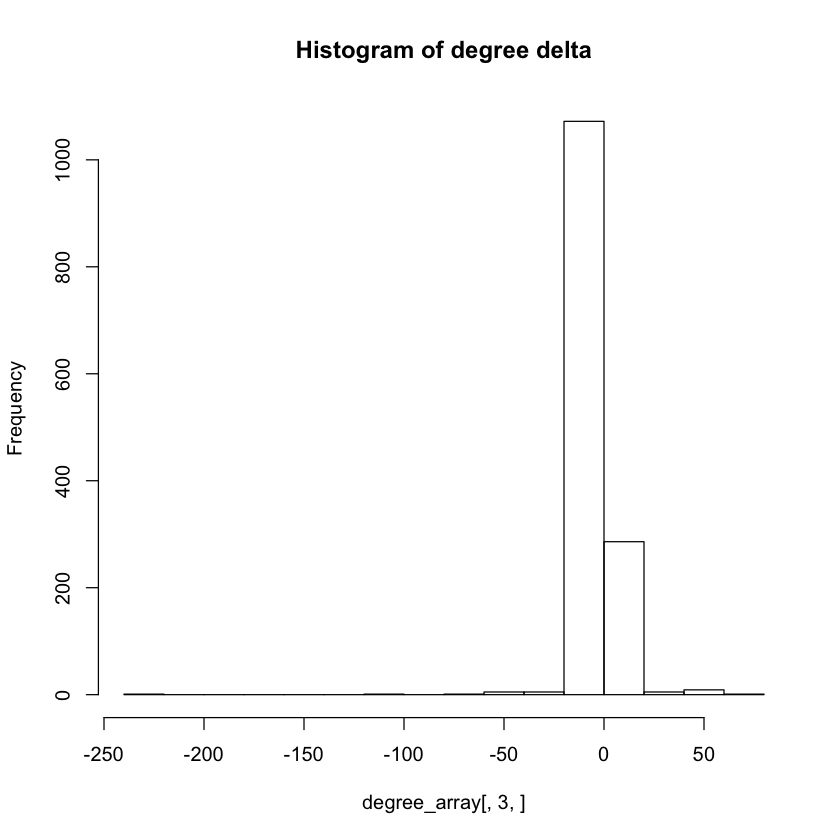

[1] "Warning: some graphs are not assigned to any cluster"
[1] "We have 1 clusters"


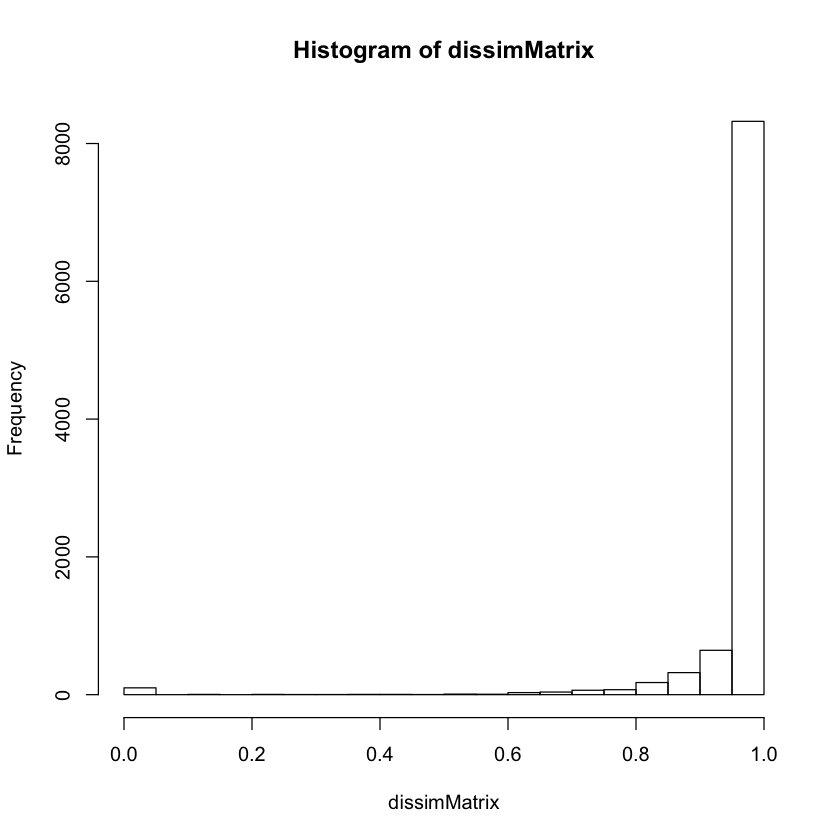

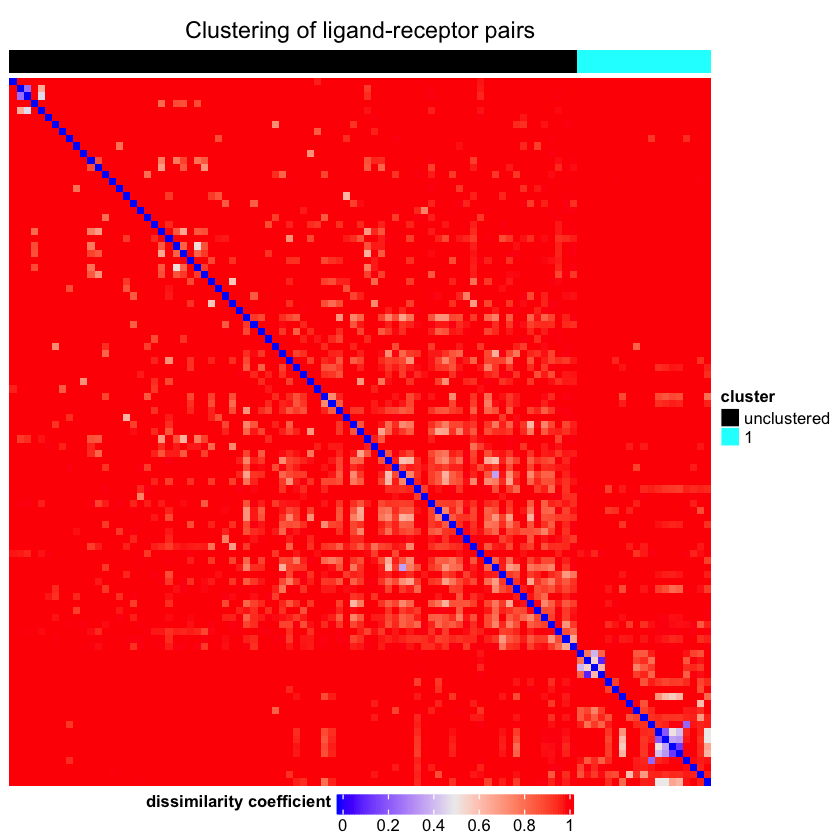

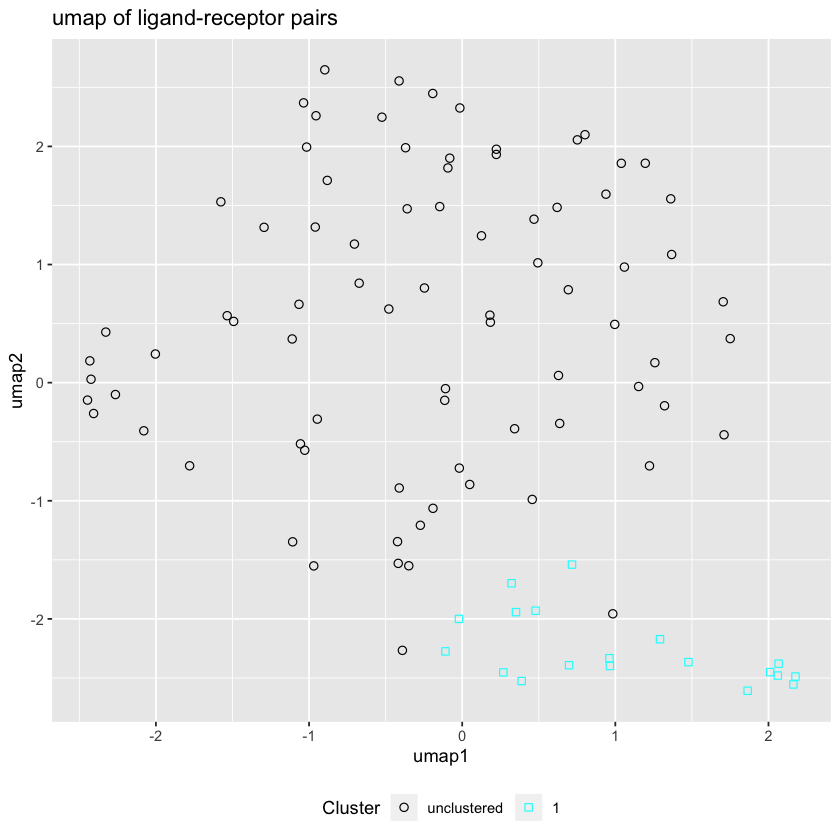

 ..cutHeight not given, setting it to 0.992  ===>  99% of the (truncated) height range in dendro.
 ..done.


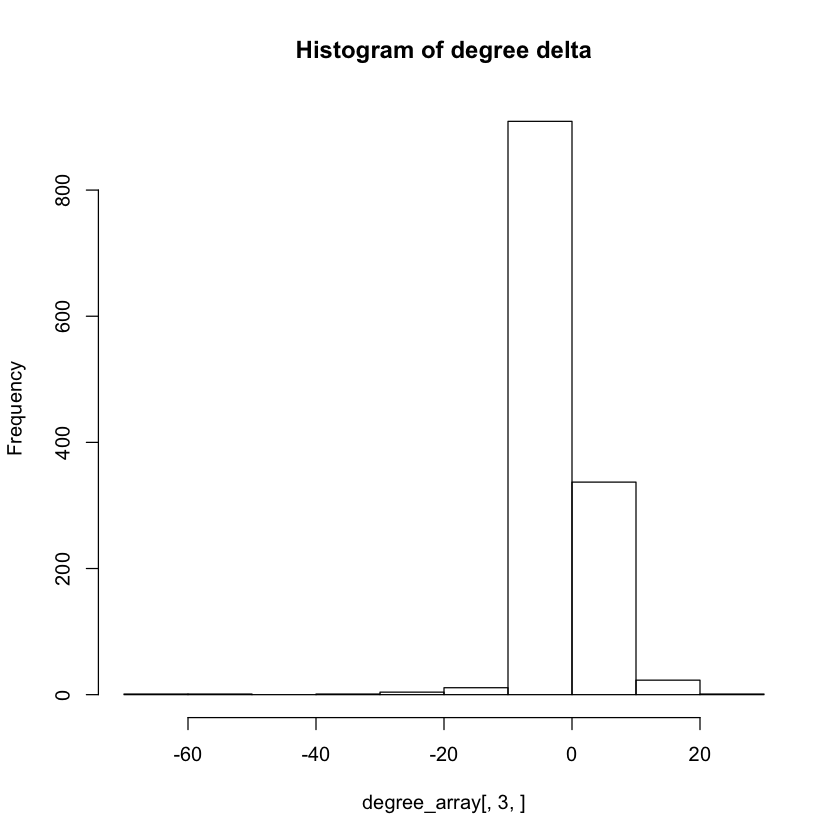

[1] "Warning: some graphs are not assigned to any cluster"
[1] "We have 2 clusters"


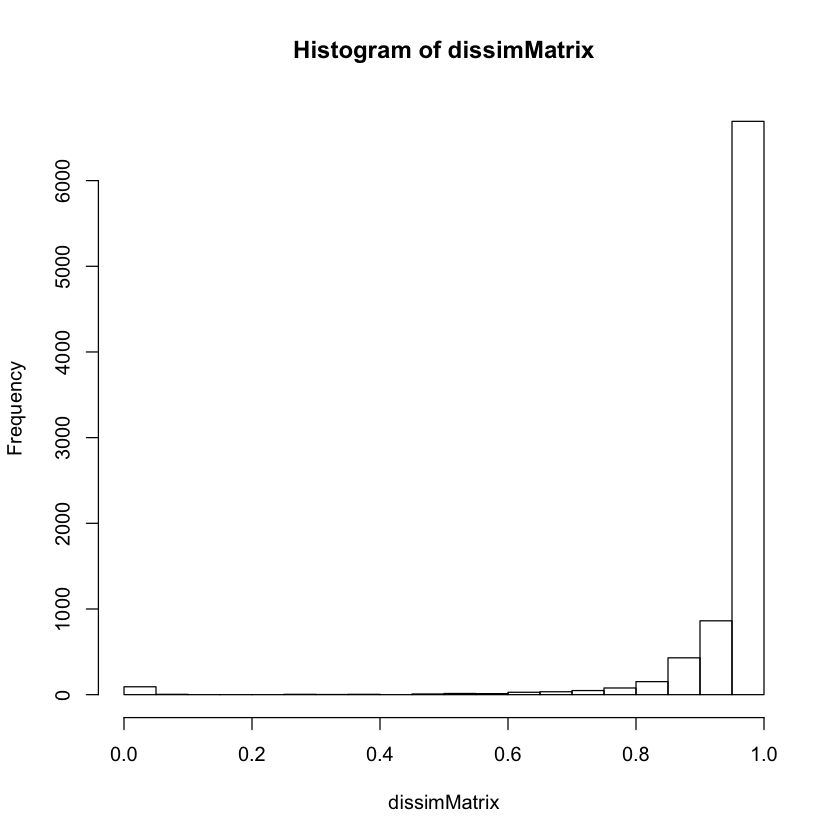

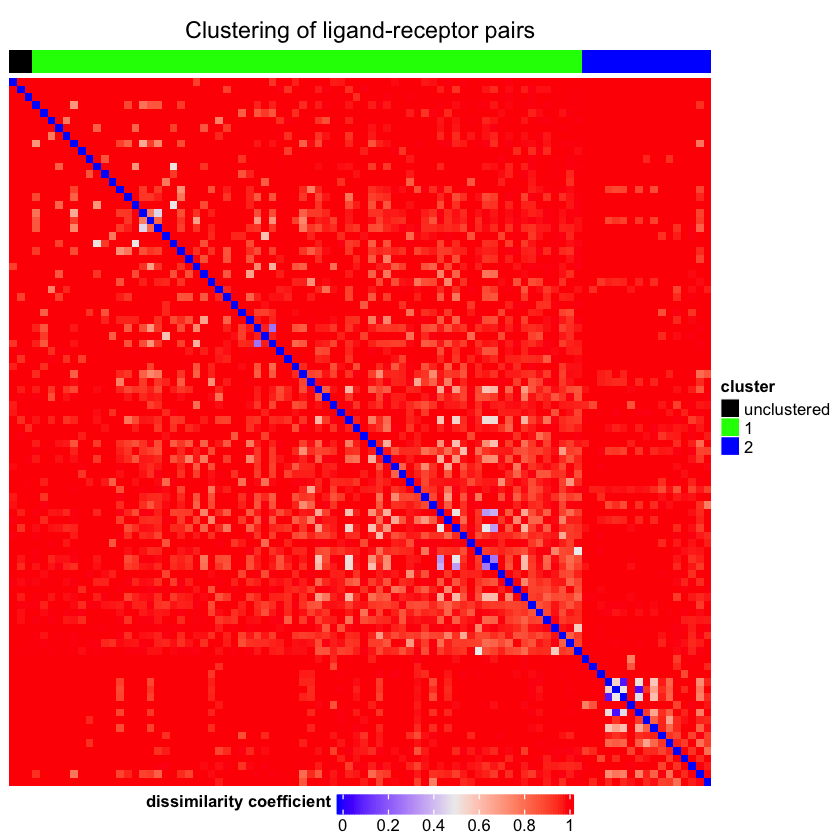

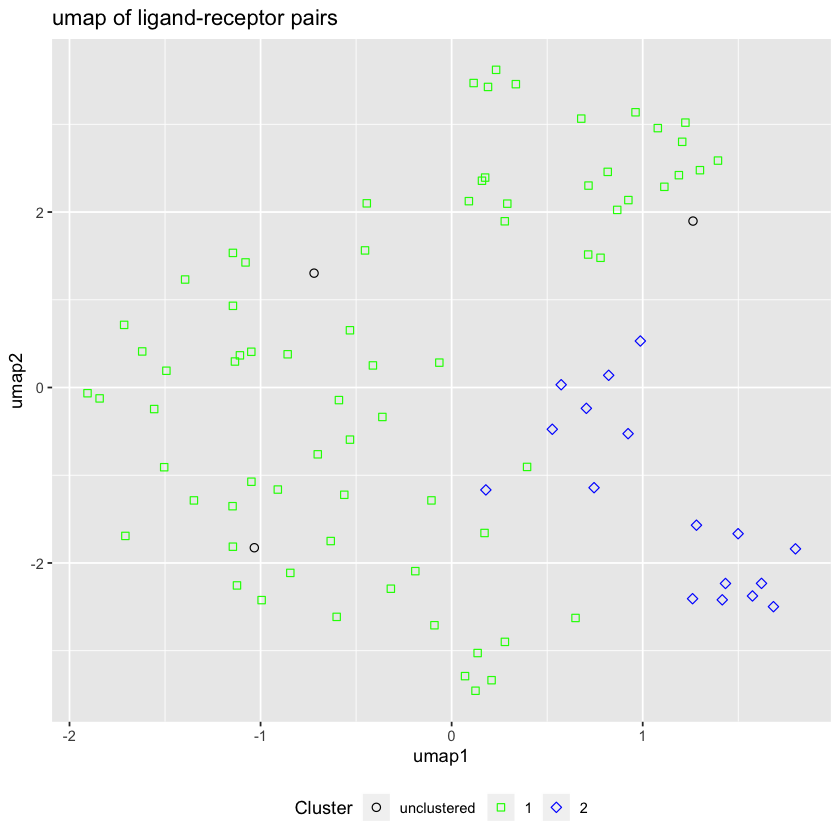

In [8]:
# Cond1 (AML328_d0)
# run communication clusters analysis
cond1_communicationClusters <- communicationClusters(weight_array = cond1_interactions$w_array
                                                     ,exprsMatrix = cond1_counts
                                                     ,annotation = cond1_annotation
                                                     ,ligandReceptorPairList = cond1_interactions$ligandReceptorPairList
                                                     ,export_results = export_results
                                                     ,outputPath = outputPath
                                                     ,minClusterSize = minClusterSize
                                                     ,complex_input = complex_input
                                                     ,gene_input = gene_input
  )

# Cond2 (AML328_d29)
# run communication clusters analysis
cond2_communicationClusters <- communicationClusters(weight_array = cond2_interactions$w_array
                                                     ,exprsMatrix = cond2_counts
                                                     ,annotation = cond2_annotation
                                                     ,ligandReceptorPairList = cond2_interactions$ligandReceptorPairList
                                                     ,export_results = export_results
                                                     ,outputPath = outputPath
                                                     ,minClusterSize = minClusterSize
                                                     ,complex_input = complex_input
                                                     ,gene_input = gene_input
  )

### Comparative analysis

Warning message in dir.create(outputPath):
“'/Users/MariaSolovey/Documents/Helmholtz/AG_Scialdone/our_papers/communication/DATASETS/AML_Bernstein_GSE116256/Tutorial_AML_PublicationFigs/comunet_output' existiert bereits”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignored”Warning message in `[.data.frame`(..., drop = FALSE):
“'drop' argument will be ignore

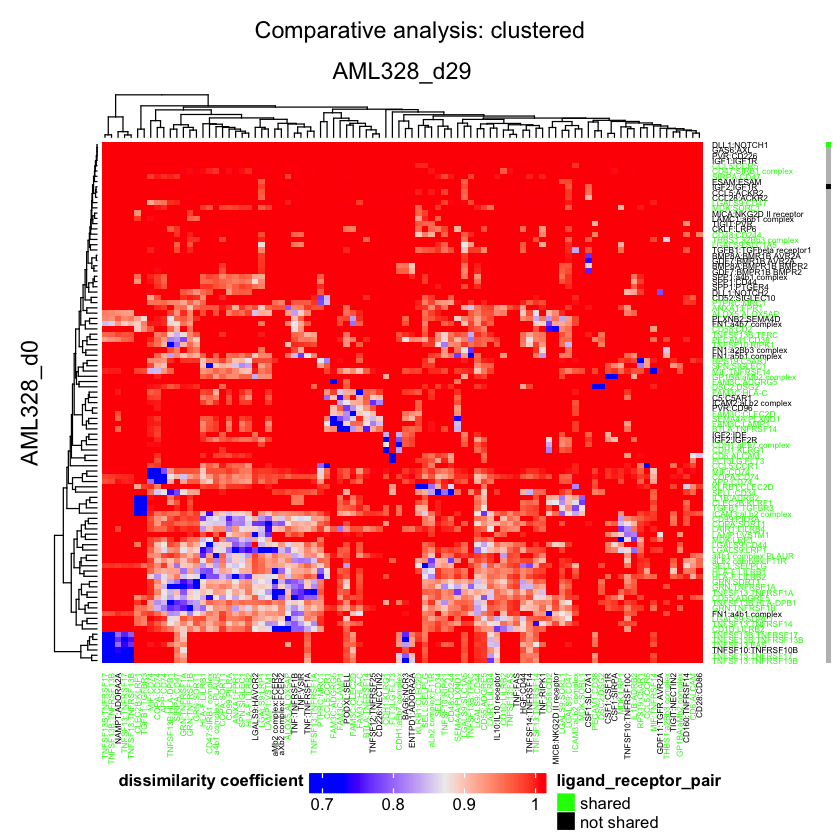

,pair,presence,dissimilarity
,<chr>,<ord>,<dbl>
CCL5:CCR5,CCL5:CCR5,shared,1.0000000
GP1BA:aMb2 complex,GP1BA:aMb2 complex,shared,1.0000000
MDK:SORL1,MDK:SORL1,shared,1.0000000
IL1B:ADRB2,IL1B:ADRB2,shared,1.0000000
CD48:CD244,CD48:CD244,shared,1.0000000
TNFSF13:FAS,TNFSF13:FAS,shared,1.0000000
LGALS9:CD47,LGALS9:CD47,shared,0.9910701
CD47:SIRB1 complex,CD47:SIRB1 complex,shared,0.9869865
SIRPA:CD47,SIRPA:CD47,shared,0.9800789


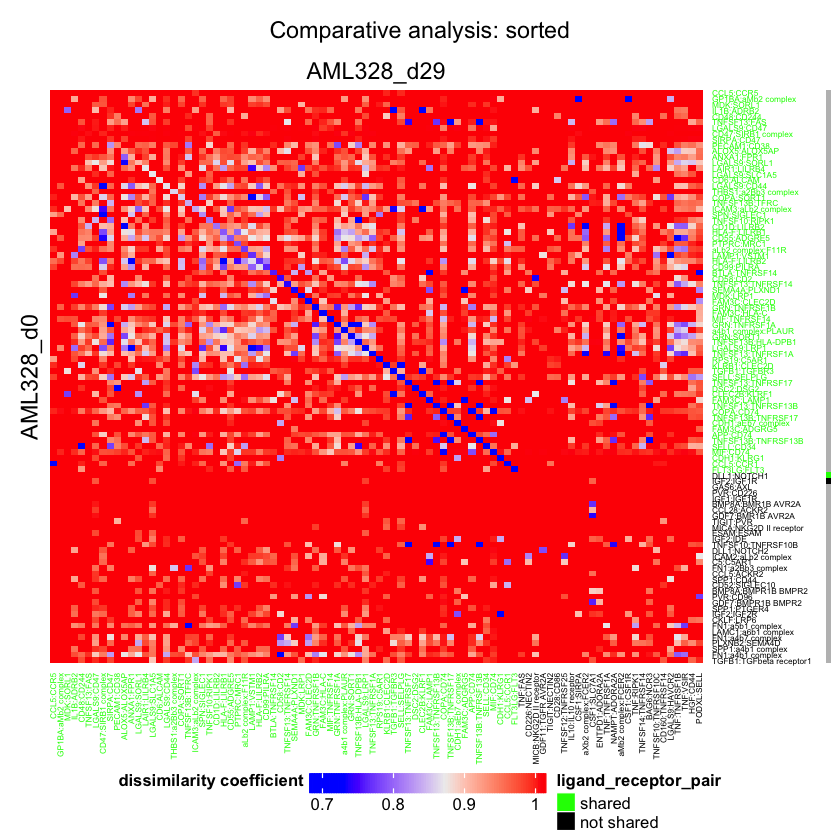

In [9]:
export_results <- T
# create output directory
if(export_results) dir.create(outputPath)
# runcomparative analysis
comparativeAnalysis(cond1_result = cond1_communicationClusters
                    ,cond2_result = cond2_communicationClusters
                    ,outputPath = outputPath
                    ,export_results = export_results
                    ,cond1_name = cond1_name
                    ,cond2_name = cond2_name
                    ,complex_input = complex_input
                    ,gene_input = gene_input
                    ,exprsMatrix1 = cond1_counts
                    ,exprsMatrix2 = cond2_counts
                    ,annotation1 = cond1_annotation
                    ,annotation2 = cond2_annotation
                    )